# 1. VK Social network analysis


## 1.1 Download your vk friends information 

1. You need to get access token, go here https://vk.com/dev and create stand alone application
    - Мои приложения
    - Создать приложение
    - Standalone


2. Access token можно найти в разделе Настройки вашего приложения, вам нужен тот который `Сервисный ключ доступа`

3. Список методов API https://vk.com/dev/methods
4. Нам потребуются методы `friends.get` и `users.get`

In [1]:
import json
import requests
from operator import itemgetter
import pandas as pd
from itertools import cycle
from tqdm.notebook import tqdm, trange
import networkx as nx
import pickle
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from scipy.stats import linregress
from pathlib import Path
import matplotlib as mpl

In [2]:
api = 'https://api.vk.com/method/'
screen_name='ilykuleshov'
access_token = '' # put your token
my_id = requests.get(f'{api}utils.resolveScreenName?screen_name={screen_name}&access_token={access_token}&v=5.131').json()['response']['object_id']

In [3]:
def get_friends_info(user_id: str, access_token, fields=None):
    if fields is None:
        fields = 'sex'
    friends_url = f'{api}friends.get?fields={fields}&access_token={access_token}&v=5.131'
    if user_id:
        friends_url += f'&user_id={user_id}'

    json_response: requests.Response = requests.get(friends_url).json()
    if json_response.get('error'):
        raise KeyError(f'Unable to access {user_id} friends.', json_response)

    return json_response[u'response']

In [4]:
fields = 'sex,city,education,bdate' # check https://vk.com/dev/users.get for all possible fields values


mates = get_friends_info(my_id, access_token, fields)

In [5]:
mates['count']

218

In [6]:
len(mates['items'])

218

In [7]:
mates['items'][1]

{'id': 1286959,
 'bdate': '20.7.1986',
 'city': {'id': 1, 'title': 'Moscow'},
 'track_code': 'b9b29568oOil81-G3QTrAQ8lsqHx_KCuABOfFA1DezHZxeyE9WrBi8TMDYLdAuQGN9B3EOyFo65pdvFw',
 'sex': 2,
 'first_name': 'Alexey',
 'last_name': 'Perepelkin',
 'can_access_closed': True,
 'is_closed': False}

## 1.2 Build an egocentric graph



Вам нужно самостоятельно написать функцию, которая из списка ваших друзей и их друзей построит такую сеть, что:
- каждая вершина в ней - ваш друг
- ребро между двумя друзьями возникает только в случае если они друг у друга в друзьях

В качестве дополнительной информации необходимо вытащить пол, дату рождения, город и образование, нам это потребуется в следующем домашнем задании. Среди прочего может быть интересно посмотреть повышает ли одинаковый пол/возраст/школа вероятность быть друг у друга в друзьях или нет. Это называется **homophily** https://en.wikipedia.org/wiki/Network_homophily 

> Поскольку вам нужно будет запустить `get_friends_info` столько раз сколько у вас друзей, это может занять какое-то время, и после обработки информацию о графе лучше сохранить.

Хранить такой граф удобно ввиде списка ребер, то есть таблицы с двумя колонками:

| Вершина 1 | Вершина 2 |
|---|---|
|user_id_1| user_id_2|
|user_id_1| user_id_3|
|user_id_2| user_id_3|

Информацию о пользователях удобно хранить в отдельной таблице:

| User id | Name | Sex | Birthday |
|---|---|---|---|
|user_id_1| Anastasia | Female | 01.02.2003 |
|user_id_2| Alex |Male| 21.01.1999|
|user_id_3| Yulia|Female| 06.05.2001|


# Сохраните две таблички: Информация о пользователях, список ребер

В качестве решения пришлите на почту kurmukovai@gmail.com с темой письма iitp-networks-2022-hw2-Фамилия jupyter-notebook с решением и две таблицы (информация о пользоавтелях и список ребер). Предварительно **удалите** из нотбука поле `access_token` (или обновите его внутри созданного приложения vk). 

In [8]:
def get_ids(mates):
    ids = map(itemgetter('id'), mates['items'])
    return list(ids)

def sorted_tuple(t):
    a, b = t

    return (a, b) if a < b else (b, a)

In [9]:
my_friends = set(get_ids(mates))
edges = set()

for mate in tqdm(mates['items']):
    try:
        mate_mates = get_friends_info(mate['id'], access_token, fields)
    except:
        continue
    
    mate_mates = get_ids(mate_mates)
    our_mates = my_friends.intersection(mate_mates)
    edges.update(
            map(sorted_tuple, zip(cycle([mate['id']]), our_mates))
        )


  0%|          | 0/218 [00:00<?, ?it/s]

In [10]:
edges_table = pd.DataFrame(edges)

columns = ['id', 'bdate', 'sex', 'first_name', 'last_name']
extract_row = lambda d: tuple(map(d.get, columns))
friends_info = pd.DataFrame(map(extract_row, mates['items']), columns=columns)

In [11]:
edges_table.to_csv('edges_table.csv', index=False)
friends_info.to_csv('friends_info.csv', index=False)

In [12]:
edges_table = pd.read_csv('edges_table.csv')
friends_info = pd.read_csv('friends_info.csv')

In [13]:
G_vk = nx.from_edgelist(edges_table.itertuples(index=False))
node_sizes = dict(G_vk.degree)
biggest_node_ids = set([k for k, v in sorted(node_sizes.items(), key=lambda x: x[1])[-10:]])
biggest_nodes = friends_info.loc[friends_info['id'].isin(biggest_node_ids)]
biggest_nodes['name'] = biggest_nodes['first_name'].apply(itemgetter(0)) + '. ' + biggest_nodes['last_name']

/tmp/ipykernel_55939/3301429415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biggest_nodes['name'] = biggest_nodes['first_name'].apply(itemgetter(0)) + '. ' + biggest_nodes['last_name']


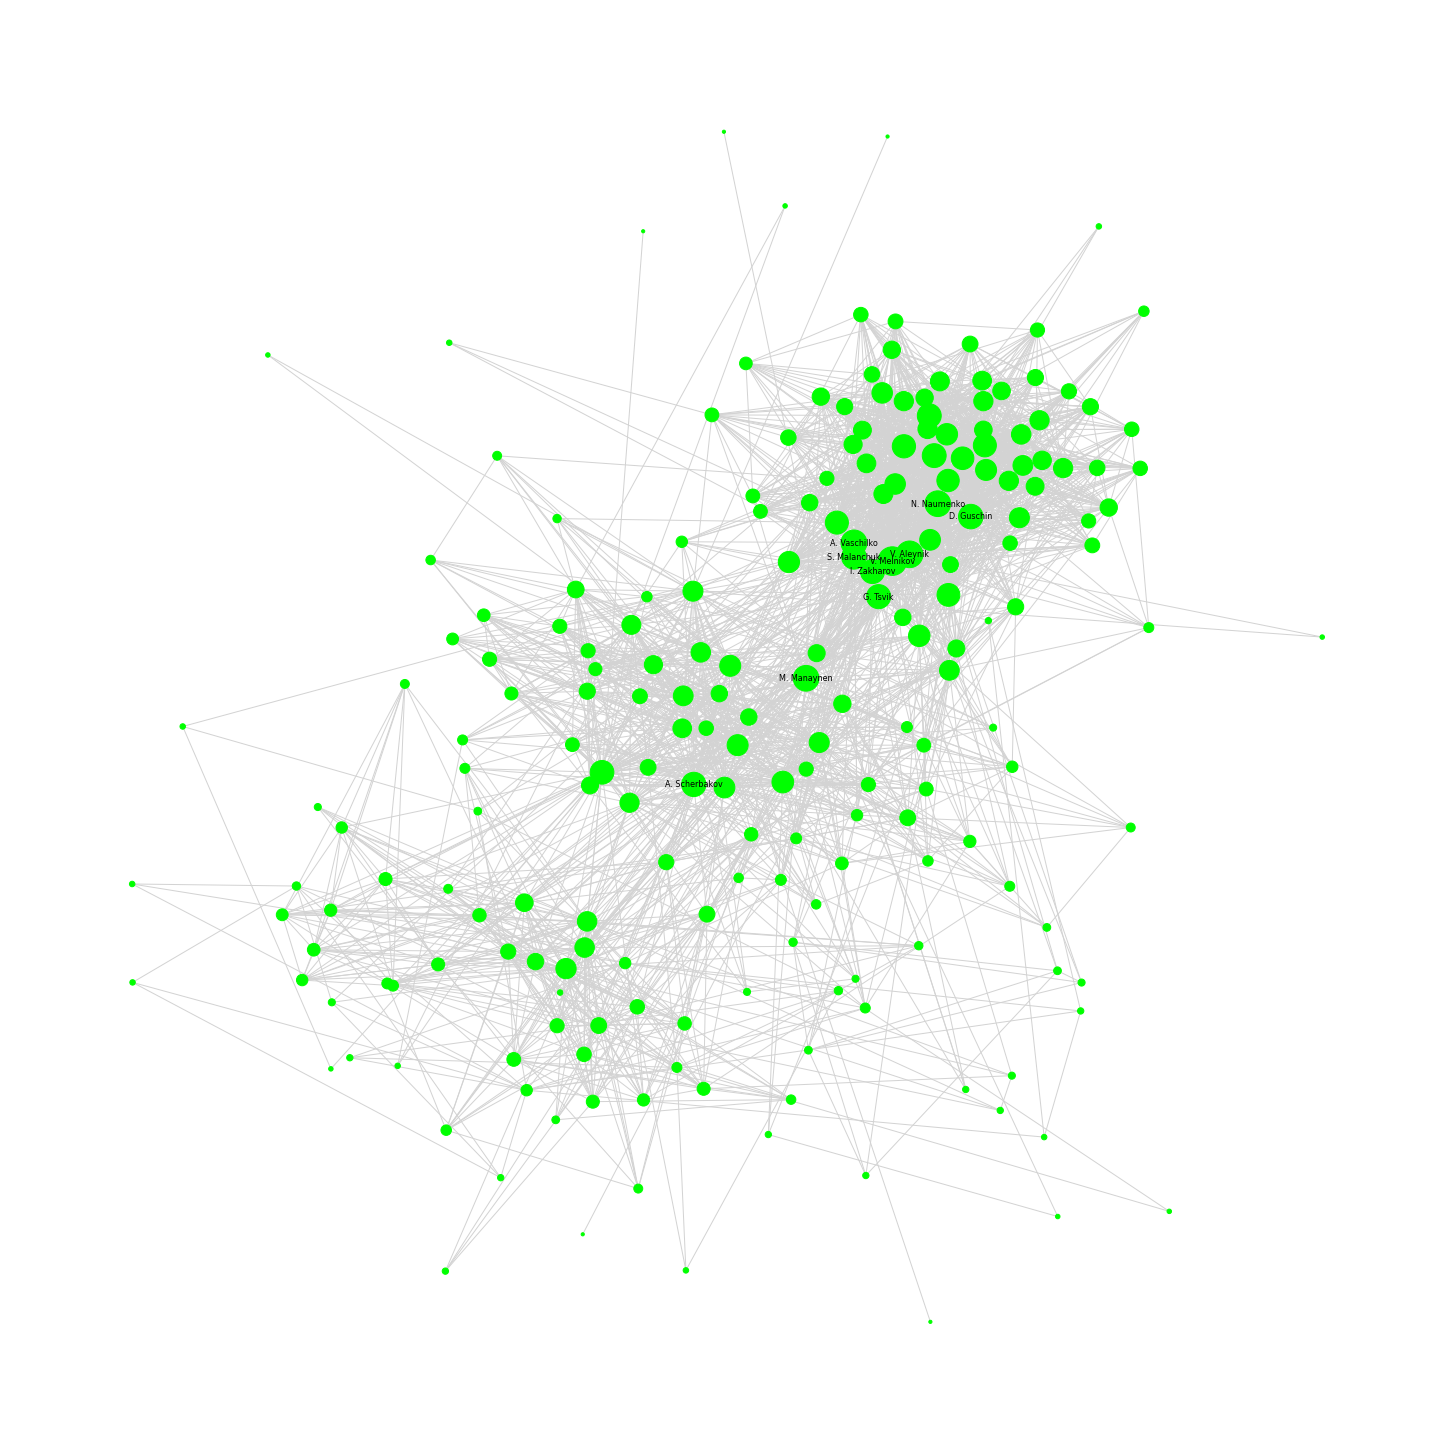

In [14]:
plt.figure(figsize=(20, 20))

nx.draw(G_vk, 
        pos=nx.layout.fruchterman_reingold_layout(G_vk, seed=8, k=0.5), 
        labels=dict(zip(biggest_node_ids, biggest_nodes['name'])), 
        node_color='lime',
        node_size=np.fromiter(node_sizes.values(), dtype=int) * 10,
        edge_color='lightgray',
        font_size=8)

# 2. Barabasi-Albert model

## 2.1. Имплементировать модель Барабаси-Альберта: 

```
def generate_barabsi_albert(n: int, **args) -> np.ndarray:
    """Generates graph with `n` nodes via a preferential attachement process. 
    Returns its adjacency matrix."""
    ...
```

In [15]:
def generate_barabsi_albert(n: int, **kwargs):
    G = nx.from_numpy_array(np.ones((3, 3)))
    for i in trange(3, n):
        degrees = np.array(list(dict(G.degree).values()), dtype=float)
        degrees /= degrees.sum()
        add_edge = np.nonzero(np.random.rand(i) < degrees)[0]

        G.add_node(i)
        G.add_edges_from(zip(cycle([i]), add_edge))

    G.remove_edges_from(nx.selfloop_edges(G))
    return G

In [16]:
G_ba = generate_barabsi_albert(300)

  0%|          | 0/297 [00:00<?, ?it/s]

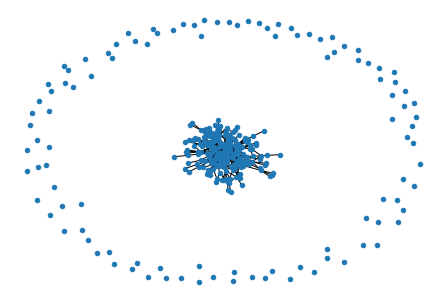

In [17]:
nx.draw(G_ba, node_size=20)

In [18]:
fname = Path('./itas_2009-2017_v8.xls')
itas_all = pd.read_excel(fname)
title_author = itas_all.groupby(by=['title', 'author_id_new']).count().reset_index()
authors, titles = title_author.title, title_author.author_id_new
inc_table = pd.crosstab(authors, titles)
adjacency_matrix = inc_table.values.T.dot(inc_table.values)
adjacency_matrix[adjacency_matrix > 1] = 1
G_itas = nx.from_numpy_matrix(adjacency_matrix)

   
## 2.2. Сравнить граф соавторств ИТИСа, ваш эгоцентрический граф и модельный граф Барабаси-Альберта (с таким же количеством вершин):
    - распределение степеней вершин в log-log шкале
    - среднюю длину пути между вершинами внутри GCC
    - величину экспоненты $\lambda$:
    
$$P(k) \propto k^{-\lambda}$$

In [19]:
def get_degree_distribution(G):
    degree_counter = Counter(dict(G.degree).values())
    degrees, counts = zip(*degree_counter.most_common())
    n_nodes = G.number_of_nodes()

    degrees = np.array(degrees, dtype=float)
    counts = np.array(counts, dtype=float) / n_nodes

    slope, intercept, r_value, p_value, std_err = linregress(np.log(degrees[1:]), np.log(counts[1:]))

    return degrees, counts, slope, intercept, std_err, p_value

In [20]:
plt.style.use('default')

Slope of VK is -0.5213484973683996, err: 0.07499715726623321, p_val that slope is 0: 3.5345785192141603e-09
Slope of BA is -1.462452220308672, err: 0.17576772257323775, p_val that slope is 0: 1.4510469746593752e-06
Slope of ITAS is -2.142222837696293, err: 0.1853041089578098, p_val that slope is 0: 3.573293832673826e-12


/tmp/ipykernel_55939/1697794849.py:11: RuntimeWarning: divide by zero encountered in power
  plt.plot(np.arange(100), np.exp(intercept) * np.arange(100) ** slope)
/tmp/ipykernel_55939/1697794849.py:11: RuntimeWarning: divide by zero encountered in power
  plt.plot(np.arange(100), np.exp(intercept) * np.arange(100) ** slope)
/tmp/ipykernel_55939/1697794849.py:11: RuntimeWarning: divide by zero encountered in power
  plt.plot(np.arange(100), np.exp(intercept) * np.arange(100) ** slope)


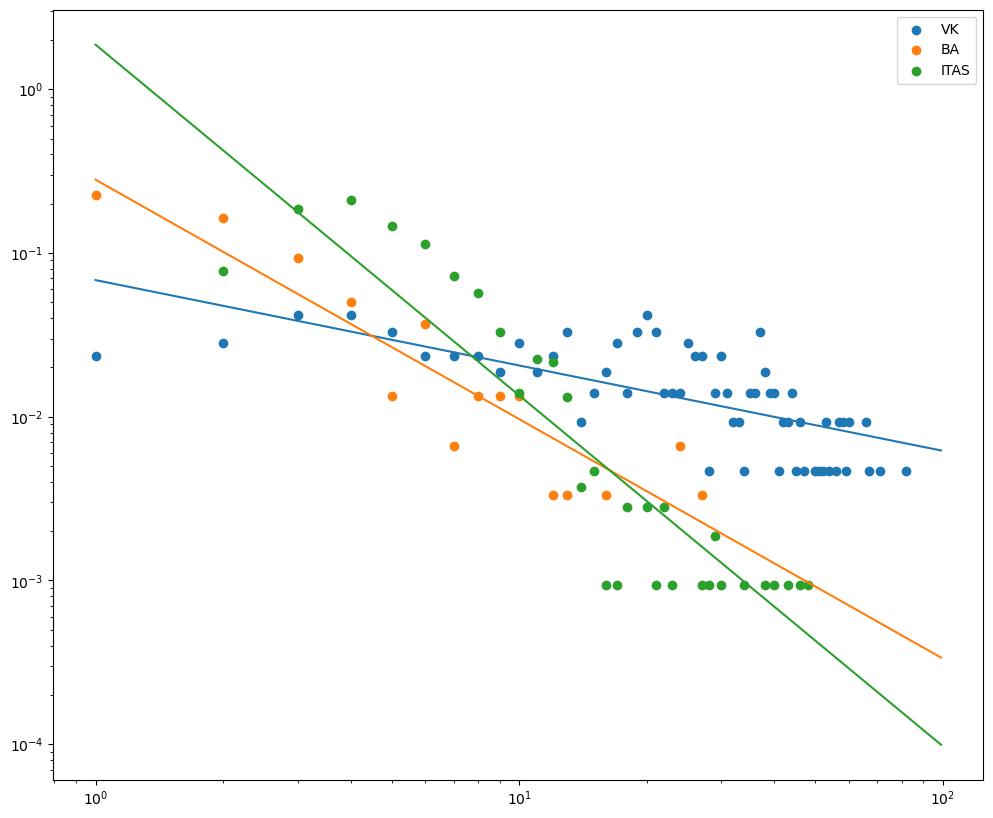

In [21]:
graphs = {'VK': G_vk, 'BA': G_ba, 'ITAS': G_itas}

fig, ax = plt.subplots(figsize=(12, 10))

ax.set_xscale('log')
ax.set_yscale('log')

for name, G in graphs.items():
    degrees, counts, slope, intercept, std_err, p_value = get_degree_distribution(G)
    ax.scatter(degrees, counts, label=name)
    plt.plot(np.arange(100), np.exp(intercept) * np.arange(100) ** slope)
    print(f"Slope of {name} is {slope}, err: {std_err}, p_val that slope is 0: {p_value}")

ax.legend()

In [22]:
def get_avg_path(G):
    gcc_nodes = sorted(nx.connected_components(G), key=len, reverse=True)[0]
    gcc = G.subgraph(gcc_nodes)

    return nx.average_shortest_path_length(gcc)

In [23]:
for name, G in graphs.items():
    print(f"Avg len of {name} is {get_avg_path(G)}")

Avg len of VK is 2.424290290026765
Avg len of BA is 3.7665344964314036
Avg len of ITAS is 6.899122874866575
